The sticky air method is a good way to simulate a free surface for Eulerian approaches, provided that its parameters are chosen carefully ($C\ll1$).

2.1.1 Isostatic timescale

$C_{isost}= \frac{3}{16\pi^{3}}(\frac{L}{h_{st}})^{3}\frac{\eta_{st}}{\eta_{ch}}$


2.1.2 Stokes timescale

$C_{Stokes}= \frac{1}{16}\frac{\Delta \rho }{\rho }(\frac{h_{model}}{h_{st}})^{3}\frac{\eta_{st}}{\eta_{ch}}$


This is the case2 in the reference, like fig.7 and fig.5

### Reference

- Crameri, F., Schmeling, H., Golabek, G. J., Duretz, T., Orendt, R., Buiter, S. J. H., ... & Tackley, P. J. (2012). A comparison of numerical surface topography calculations in geodynamic modelling: an evaluation of the ‘sticky air’method. Geophysical Journal International, 189(1), 38-54.

In [1]:
import underworld as uw
from underworld import function as fn
import underworld.visualisation as vis

from underworld.scaling import units as u
from underworld.scaling import dimensionalise 
from underworld.scaling import non_dimensionalise as nd

import math
import numpy as np
import os

In [2]:
# build reference units
KL_meters   = 850 * u.kilometer
K_viscosity = 1e21  * u.pascal * u.second
K_density   = 3300 * u.kilogram / u.meter**3

# compute dependent scaling units 
#KT_seconds = 1000*u.kiloyear
#KM_kilograms = KT_seconds * KL_meters * K_viscosity
KM_kilograms = K_density * KL_meters**3
KT_seconds   = KM_kilograms / ( KL_meters * K_viscosity )
K_substance  = 1. * u.mole
#Kt_degrees   = 1. * u.kelvin

scaling_coefficients = uw.scaling.get_coefficients()
scaling_coefficients["[length]"]      = KL_meters.to_base_units()
#scaling_coefficients["[temperature]"] = Kt_degrees.to_base_units()
scaling_coefficients["[time]"]        = KT_seconds.to_base_units()
scaling_coefficients["[mass]"]        = KM_kilograms.to_base_units()

gravity = nd(10. * u.meter / u.second**2)

ymaxCoord = nd(850.* u.kilometer)
yminCoord = nd(0.* u.kilometer)
xmaxCoord = nd(2800.* u.kilometer)
xminCoord = nd(0.* u.kilometer)

In [3]:
# In the present Case 2, the relaxation time is about 15 ka 
DT = nd(2.5e3*u.year) #DT = nd(5e4*u.year)

maxSteps   = int(nd(4e6*u.year)/DT+1)
steps_output = int(nd(0.5e6*u.year)/DT)

xRes,yRes        = 560,340
RESTART = 0

# output
outputPath ="Crameri2012Case2_noVo_2.5ka/"

# search and build, if required, an output path
if uw.mpi.rank==0:
    try:
        if not os.path.exists("./"+outputPath+"/"):
            os.makedirs("./"+outputPath+'/')
    except:
        raise
        
bufsize=0
outfile = open(outputPath+'time.txt', 'wb',bufsize)

In [4]:
# build mesh and mesh variables
mesh = uw.mesh.FeMesh_Cartesian( elementType = 'Q1/dQ0', 
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = [xminCoord,yminCoord], 
                                 maxCoord    = [xmaxCoord,ymaxCoord],
                                 periodic    = [False, False])

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [5]:
# Create a swarm.
hmax =  1.0  #nd(850* u.kilometer)
hw = nd(150.* u.kilometer)
hLith = nd(100.* u.kilometer)
rPlume = nd(50.* u.kilometer)  
x0Plume = nd(1400.* u.kilometer) 
y0Plume =  nd(300.* u.kilometer)

swarm = uw.swarm.Swarm( mesh=mesh,particleEscape=True)
swarm2 = uw.swarm.Swarm( mesh=mesh, particleEscape=True)

materialVariable   = swarm.add_variable( dataType="int", count=1 )
# if (RESTART == 1):
#         swarm.load(inputPath+"swarm"+ str(step).zfill(4)+".h5")
#         swarm2.load(inputPath+"surfaceSwarm"+ str(step).zfill(4)+".h5")
#         materialVariable.load(inputPath+"material"+ str(step).zfill(4)+".h5")

# else:
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=36 )
#swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

surfacePoints = np.zeros((5000,2))
surfacePoints[:,0] = np.linspace(xminCoord, xmaxCoord, 5000)
for index in range( len(surfacePoints[:,0]) ):
    surfacePoints[index,1] = hmax-hw

swarm2.add_particles_with_coordinates(surfacePoints)


# create pop control object
#pop_control = uw.swarm.PopulationControl(swarm, deleteThreshold=0.025, splitThreshold=0.2,particlesPerCell=36)
pop_control = uw.swarm.PopulationControl(swarm,aggressive=True,splitThreshold=0.15, maxDeletions=2,maxSplits=10,particlesPerCell=36)

In [6]:
# Allocate materials to particles
MantleIndex = 0
LithIndex   = 1
PlumeIndex = 2
AirIndex = 3

#if (RESTART == 0):
    # initialise everying to be upper mantle material
materialVariable.data[:] = MantleIndex

# change matieral index if the particle is not mantle
for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    if math.sqrt((coord[0]-x0Plume)**2+(coord[1]-y0Plume)**2) < rPlume:
        materialVariable.data[index]     = PlumeIndex
    elif coord[1] > hmax-hw-hLith:
        if coord[1] < hmax-hw:
            materialVariable.data[index]     = LithIndex
        else:
            materialVariable.data[index]     = AirIndex


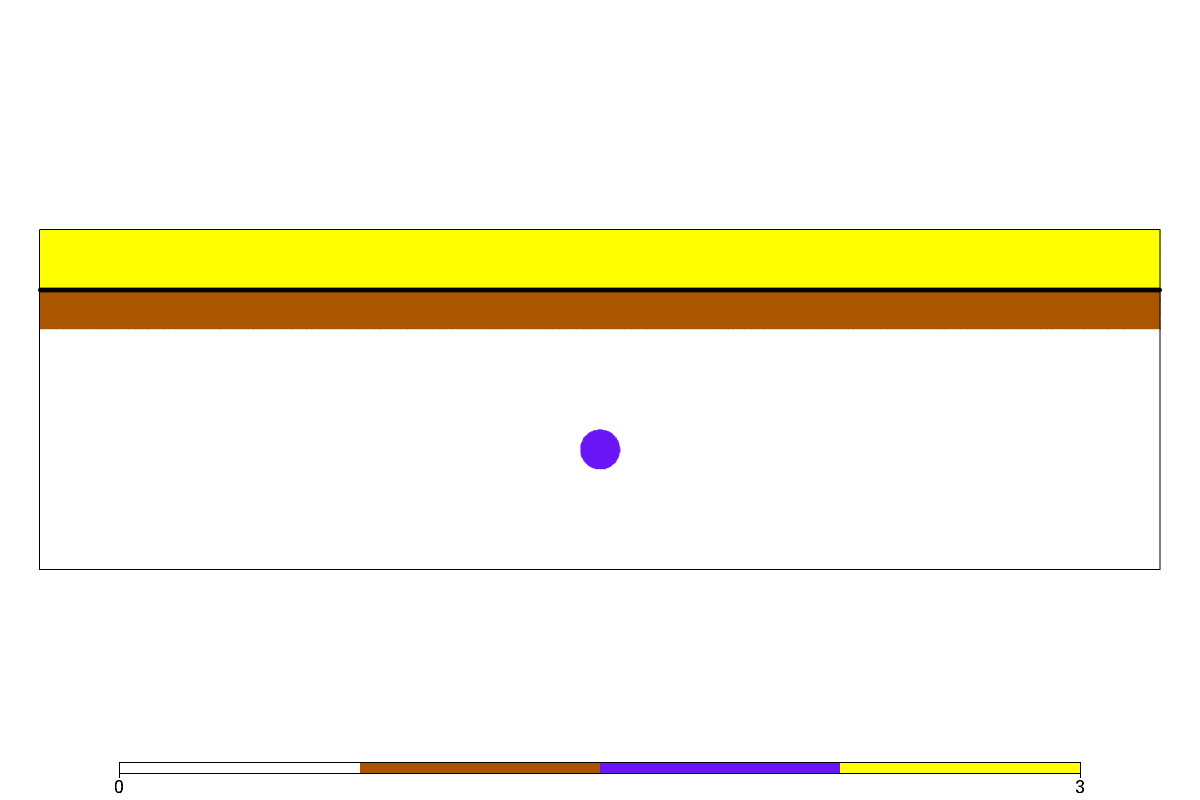

In [7]:
# Plot the initial positions for the particle swarm and colour by material type
figParticle = vis.Figure( figsize=(1200,800),quality=2)
figParticle.append (vis.objects.Points(swarm2,pointSize=5, colourBar=False))
figParticle.append( vis.objects.Points(swarm, materialVariable, pointSize=2, colours='white green red purple blue yellow',discrete=True) )
figParticle.show()

In [8]:
# **Viscosity function**
visosity_mantle = nd(1e21 * u.pascal * u.second)
visosity_plume = nd(1e20 * u.pascal * u.second)
visosity_lith = nd(1e23 * u.pascal * u.second)
visosity_air = nd(1e19 * u.pascal * u.second)


strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant( strainRateFn )

coord = fn.input()
viscosityMap = {LithIndex:visosity_lith, 
                MantleIndex:visosity_mantle, 
                PlumeIndex:visosity_plume, 
                AirIndex:visosity_air}


viscosityFn   = fn.branching.map( fn_key = materialVariable,
                                           mapping = viscosityMap )

devStressFn = 2.0 * viscosityFn * strainRateFn

In [9]:
# **Set the density function, vertical unit vector and Buoyancy Force function**
density_mantle = nd(3300. * u.kilogram / u.meter**3)
density_plume = nd(3200. * u.kilogram / u.meter**3)
density_lith = nd(3300. * u.kilogram / u.meter**3)
density_air = nd(0. * u.kilogram / u.meter**3)

densityMap = { LithIndex:density_lith,
              MantleIndex:density_mantle,
              PlumeIndex:density_plume,
              AirIndex:density_air}

densityFn = fn.branching.map( fn_key=materialVariable, mapping=densityMap ) 
# And the final buoyancy force function.
z_hat = ( 0.0, -1.0 )

buoyancyFn = densityFn * z_hat*gravity
#buoyancyFn = ( 0.0, -1.0 )

# figbuoyancy = glucifer.Figure( figsize=(1200,800),quality=2)
# figbuoyancy.append( glucifer.objects.Points(swarm, densityFn, pointSize=3.0, valueRange=None,
#                                                      colours="red yellow blue", logScale=False) )
# figbuoyancy.show()

In [10]:
# **Set initial and boundary conditions**

leftrightWalls = mesh.specialSets['Left_VertexSet'] + mesh.specialSets['Right_VertexSet']
topWalls  = mesh.specialSets[ 'Top_VertexSet'] 

bottWalls = mesh.specialSets['Bottom_VertexSet']
VelBC = uw.conditions.DirichletCondition(velocityField, (leftrightWalls+bottWalls,topWalls+bottWalls))

In [11]:
# **System and solver Setup**

stokes = uw.systems.Stokes(    velocityField = velocityField,
                               pressureField = pressureField,
                               #voronoi_swarm = swarm,
                               conditions    = VelBC,
                               fn_viscosity  = viscosityFn,
                               fn_bodyforce  = buoyancyFn )


solver = uw.systems.Solver(stokes)

# "mumps" is a good alternative for "lu" but 
# not every petsc installation has mumps !
# It also works fine in parallel
# if LargePenalty == 1:
#     solver.set_penalty(1.0e6)
#     solver.set_inner_method("mumps")
#     # use "lu" direct solve and large penalty (if running in serial)
#     #if(uw.nProcs()==1):
#     #    solver.set_inner_method("lu")
# else:
#     solver.set_penalty(1.0e2)
#     solver.set_inner_method("mg")
#     solver.options.mg.levels = 6
#solver.options.scr.ksp_rtol=1.0e-8

# Optional solver settings
# if(uw.mpi.size==1):
solver.set_inner_method("lu")
stokes_inner_tol = 1e-6
stokes_outer_tol = 1e-5
solver.set_inner_rtol(stokes_inner_tol) 
solver.set_outer_rtol(stokes_outer_tol) 
solver.set_penalty(0.0)
#solver.set_penalty(1.0e6)

# solver.set_penalty(1.0e6)
# solver.set_inner_method("mumps")
# solver.options.scr.ksp_rtol=1.0e-8
    
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
advector2 = uw.systems.SwarmAdvector( swarm=swarm2, velocityField=velocityField, order=2 )

In [12]:
# **Main simulation loop**
# define an update function

meshFileHandle = mesh.save(outputPath+"Mesh.h5")

def update():
    # Retrieve the maximum possible timestep for the advection system.
    #uw.barrier()
    dt1 = advector.get_max_dt()
    dt = DT
    # Advect using this timestep size.
    advector.integrate(dt,update_owners=True)
    advector2.integrate(dt,update_owners=True)

    # particle population control
    #if (step%5 ==0):
    pop_control.repopulate()
    #uw.barrier()

    if (step%steps_output ==0):
        mHnd=mesh.save(outputPath+"mesh"+ str(step).zfill(4)+".h5")
        #s1Hnd=swarm.save(outputPath+"swarm"+ str(step).zfill(4)+".h5")
        swarm2.save(outputPath+"surfaceSwarm"+ str(step).zfill(4)+".h5")
        matHnd=materialVariable.save(outputPath+"material"+ str(step).zfill(4)+".h5")        
         
        filename = outputPath+"velocityField."+str(step).zfill(4)
        vFH      = velocityField.save(filename+".h5")
        velocityField.xdmf( filename, vFH, "velocity", meshFileHandle, "Mesh", time )
        
        filename = outputPath+"pressureField."+str(step).zfill(4)
        pFH      = pressureField.save(filename+".h5")
        pressureField.xdmf(filename, pFH, "pressure", meshFileHandle, "Mesh", time )
        
        outputFilename = outputPath+"image"+str(step).zfill(4)
        figParticle.save_image(outputFilename)
        
    return dt, time+dt, step+1

In [13]:
# add velocity BC for stokes solver
dtStep=0.0
step = 0
time = 0.0
while step < maxSteps:
    # Solve non linear Stokes system
    #solver.solve(nonLinearIterate=True,nonLinearMaxIterations=200,nonLinearTolerance=0.003)
    solver.solve(nonLinearIterate=False)
    solver.print_stats()


    # output figure to file at intervals = steps_output
    #if uw.rank()==0:
    print('step = {0:6d}; time = {1:.3e}; dt = {1:.3e}'.format(step,dimensionalise(time, u.kiloyear),dimensionalise(dtStep, u.kiloyear)))
    string = "{0}; {1:.3e}; {1:.3e}\n".format(step,dimensionalise(time, u.kiloyear).m,dimensionalise(dtStep, u.kiloyear).m)
    outfile.write(string.encode())
    # update
    dtStep,time,step = update()


 
Pressure iterations:  16
Velocity iterations:   1 (presolve)      
Velocity iterations:  16 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  18 (total solve)   
 
SCR RHS  setup time: 1.4727e+01
SCR RHS  solve time: 8.6284e-02
Pressure setup time: 5.6220e-02
Pressure solve time: 2.0559e+00
Velocity setup time: 6.5400e-07 (backsolve)
Velocity solve time: 1.0404e-01 (backsolve)
Total solve time   : 1.7155e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =      0; time = 0.000e+00 kiloyear; dt = 0.000e+00 kiloyear

 
Pressure iterations:  21
Velocity iterations:   1 (presolve)      
Velocity iterations:  21 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  23 (total solve)   
 
SCR RHS  setup time: 1.6268e+01
SCR RHS  solve time: 8.5576e-02
Pressure setup time: 2.6089e-02
Pressure solve time: 2.6859e+00
Velocity setup time: 6.9900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  56
Velocity iterations:   1 (presolve)      
Velocity iterations:  57 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  59 (total solve)   
 
SCR RHS  setup time: 2.1204e+01
SCR RHS  solve time: 9.2810e-02
Pressure setup time: 3.1674e-02
Pressure solve time: 7.7433e+00
Velocity setup time: 6.4800e-07 (backsolve)
Velocity solve time: 1.4035e-01 (backsolve)
Total solve time   : 2.9346e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     14; time = 3.500e+01 kiloyear; dt = 3.500e+01 kiloyear

 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 2.1341e+01
SCR RHS  solve time: 9.1686e-02
Pressure setup time: 3.1881e-02
Pressure solve time: 8.0654e+00
Velocity setup time: 6.5500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  60
Velocity iterations:   1 (presolve)      
Velocity iterations:  61 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  63 (total solve)   
 
SCR RHS  setup time: 2.7391e+01
SCR RHS  solve time: 1.5562e-01
Pressure setup time: 3.3452e-02
Pressure solve time: 1.1695e+01
Velocity setup time: 8.1400e-07 (backsolve)
Velocity solve time: 1.1779e-01 (backsolve)
Total solve time   : 3.9571e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     28; time = 7.000e+01 kiloyear; dt = 7.000e+01 kiloyear

 
Pressure iterations:  60
Velocity iterations:   1 (presolve)      
Velocity iterations:  61 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  63 (total solve)   
 
SCR RHS  setup time: 1.9618e+01
SCR RHS  solve time: 1.1671e-01
Pressure setup time: 5.1507e-02
Pressure solve time: 1.2802e+01
Velocity setup time: 7.2900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  59
Velocity iterations:   1 (presolve)      
Velocity iterations:  60 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  62 (total solve)   
 
SCR RHS  setup time: 1.7734e+01
SCR RHS  solve time: 1.0648e-01
Pressure setup time: 5.6987e-02
Pressure solve time: 8.7595e+00
Velocity setup time: 9.0300e-07 (backsolve)
Velocity solve time: 1.2205e-01 (backsolve)
Total solve time   : 2.6930e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     42; time = 1.050e+02 kiloyear; dt = 1.050e+02 kiloyear

 
Pressure iterations:  59
Velocity iterations:   1 (presolve)      
Velocity iterations:  60 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  62 (total solve)   
 
SCR RHS  setup time: 1.8608e+01
SCR RHS  solve time: 9.4423e-02
Pressure setup time: 3.2932e-02
Pressure solve time: 9.8640e+00
Velocity setup time: 7.5500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  58
Velocity iterations:   1 (presolve)      
Velocity iterations:  59 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  61 (total solve)   
 
SCR RHS  setup time: 2.1198e+01
SCR RHS  solve time: 2.5521e-01
Pressure setup time: 4.6494e-02
Pressure solve time: 1.4361e+01
Velocity setup time: 8.3200e-07 (backsolve)
Velocity solve time: 2.7739e-01 (backsolve)
Total solve time   : 3.6431e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     56; time = 1.400e+02 kiloyear; dt = 1.400e+02 kiloyear

 
Pressure iterations:  56
Velocity iterations:   1 (presolve)      
Velocity iterations:  57 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  59 (total solve)   
 
SCR RHS  setup time: 2.1147e+01
SCR RHS  solve time: 1.3055e-01
Pressure setup time: 4.7003e-02
Pressure solve time: 1.1126e+01
Velocity setup time: 6.0600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  52
Velocity iterations:   1 (presolve)      
Velocity iterations:  53 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  55 (total solve)   
 
SCR RHS  setup time: 1.7669e+01
SCR RHS  solve time: 1.4557e-01
Pressure setup time: 6.6184e-02
Pressure solve time: 6.6342e+00
Velocity setup time: 4.9500e-07 (backsolve)
Velocity solve time: 1.0700e-01 (backsolve)
Total solve time   : 2.4764e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     70; time = 1.750e+02 kiloyear; dt = 1.750e+02 kiloyear

 
Pressure iterations:  52
Velocity iterations:   1 (presolve)      
Velocity iterations:  53 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  55 (total solve)   
 
SCR RHS  setup time: 1.5960e+01
SCR RHS  solve time: 1.1037e-01
Pressure setup time: 6.4545e-02
Pressure solve time: 7.6322e+00
Velocity setup time: 1.0790e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 2.0851e+01
SCR RHS  solve time: 1.1748e-01
Pressure setup time: 6.3911e-02
Pressure solve time: 1.1337e+01
Velocity setup time: 1.1050e-06 (backsolve)
Velocity solve time: 1.9295e-01 (backsolve)
Total solve time   : 3.2739e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     84; time = 2.100e+02 kiloyear; dt = 2.100e+02 kiloyear

 
Pressure iterations:  57
Velocity iterations:   1 (presolve)      
Velocity iterations:  58 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  60 (total solve)   
 
SCR RHS  setup time: 2.0248e+01
SCR RHS  solve time: 1.0452e-01
Pressure setup time: 3.2366e-02
Pressure solve time: 8.1461e+00
Velocity setup time: 7.7100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  49
Velocity iterations:   1 (presolve)      
Velocity iterations:  50 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  52 (total solve)   
 
SCR RHS  setup time: 2.1075e+01
SCR RHS  solve time: 1.1769e-01
Pressure setup time: 3.3804e-02
Pressure solve time: 7.4742e+00
Velocity setup time: 8.5900e-07 (backsolve)
Velocity solve time: 1.2978e-01 (backsolve)
Total solve time   : 2.8990e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =     98; time = 2.450e+02 kiloyear; dt = 2.450e+02 kiloyear

 
Pressure iterations:  49
Velocity iterations:   1 (presolve)      
Velocity iterations:  50 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  52 (total solve)   
 
SCR RHS  setup time: 2.2030e+01
SCR RHS  solve time: 1.2006e-01
Pressure setup time: 4.0961e-02
Pressure solve time: 9.2273e+00
Velocity setup time: 1.0870e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  51
Velocity iterations:   1 (presolve)      
Velocity iterations:  52 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  54 (total solve)   
 
SCR RHS  setup time: 1.8944e+01
SCR RHS  solve time: 1.7549e-01
Pressure setup time: 3.5601e-02
Pressure solve time: 1.1457e+01
Velocity setup time: 1.3270e-06 (backsolve)
Velocity solve time: 2.4036e-01 (backsolve)
Total solve time   : 3.1100e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    112; time = 2.800e+02 kiloyear; dt = 2.800e+02 kiloyear

 
Pressure iterations:  51
Velocity iterations:   1 (presolve)      
Velocity iterations:  52 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  54 (total solve)   
 
SCR RHS  setup time: 3.3581e+01
SCR RHS  solve time: 1.7658e-01
Pressure setup time: 3.8827e-02
Pressure solve time: 1.5053e+01
Velocity setup time: 7.5000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  45
Velocity iterations:   1 (presolve)      
Velocity iterations:  46 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  48 (total solve)   
 
SCR RHS  setup time: 1.8167e+01
SCR RHS  solve time: 1.1036e-01
Pressure setup time: 3.7273e-02
Pressure solve time: 7.5883e+00
Velocity setup time: 8.1100e-07 (backsolve)
Velocity solve time: 1.4084e-01 (backsolve)
Total solve time   : 2.6199e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    126; time = 3.150e+02 kiloyear; dt = 3.150e+02 kiloyear

 
Pressure iterations:  50
Velocity iterations:   1 (presolve)      
Velocity iterations:  51 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  53 (total solve)   
 
SCR RHS  setup time: 1.8153e+01
SCR RHS  solve time: 1.1824e-01
Pressure setup time: 3.3402e-02
Pressure solve time: 7.6627e+00
Velocity setup time: 7.8700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 1.8274e+01
SCR RHS  solve time: 1.1583e-01
Pressure setup time: 3.4745e-02
Pressure solve time: 7.9858e+00
Velocity setup time: 1.5120e-06 (backsolve)
Velocity solve time: 1.2834e-01 (backsolve)
Total solve time   : 2.6681e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    140; time = 3.500e+02 kiloyear; dt = 3.500e+02 kiloyear

 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 2.0441e+01
SCR RHS  solve time: 1.1219e-01
Pressure setup time: 3.8306e-02
Pressure solve time: 8.0430e+00
Velocity setup time: 7.7200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 2.0396e+01
SCR RHS  solve time: 1.0881e-01
Pressure setup time: 7.3180e-02
Pressure solve time: 8.0317e+00
Velocity setup time: 1.1120e-06 (backsolve)
Velocity solve time: 1.2194e-01 (backsolve)
Total solve time   : 2.8884e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    154; time = 3.850e+02 kiloyear; dt = 3.850e+02 kiloyear

 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 2.1418e+01
SCR RHS  solve time: 1.1288e-01
Pressure setup time: 3.4657e-02
Pressure solve time: 8.0643e+00
Velocity setup time: 1.2380e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 2.1566e+01
SCR RHS  solve time: 1.0428e-01
Pressure setup time: 3.4404e-02
Pressure solve time: 7.8687e+00
Velocity setup time: 6.2200e-07 (backsolve)
Velocity solve time: 1.2814e-01 (backsolve)
Total solve time   : 2.9851e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    168; time = 4.200e+02 kiloyear; dt = 4.200e+02 kiloyear

 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 1.9302e+01
SCR RHS  solve time: 1.5115e-01
Pressure setup time: 3.3636e-02
Pressure solve time: 1.0558e+01
Velocity setup time: 4.5110e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.9261e+01
SCR RHS  solve time: 1.4665e-01
Pressure setup time: 6.8454e-02
Pressure solve time: 9.5746e+00
Velocity setup time: 1.2380e-06 (backsolve)
Velocity solve time: 1.6229e-01 (backsolve)
Total solve time   : 2.9400e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    182; time = 4.550e+02 kiloyear; dt = 4.550e+02 kiloyear

 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.7674e+01
SCR RHS  solve time: 1.4689e-01
Pressure setup time: 7.4798e-02
Pressure solve time: 9.2827e+00
Velocity setup time: 8.3700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  56
Velocity iterations:   1 (presolve)      
Velocity iterations:  57 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  59 (total solve)   
 
SCR RHS  setup time: 1.7359e+01
SCR RHS  solve time: 1.3262e-01
Pressure setup time: 3.1112e-02
Pressure solve time: 9.3663e+00
Velocity setup time: 1.1400e-06 (backsolve)
Velocity solve time: 1.5124e-01 (backsolve)
Total solve time   : 2.7200e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    196; time = 4.900e+02 kiloyear; dt = 4.900e+02 kiloyear

 
Pressure iterations:  56
Velocity iterations:   1 (presolve)      
Velocity iterations:  57 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  59 (total solve)   
 
SCR RHS  setup time: 1.7368e+01
SCR RHS  solve time: 1.1821e-01
Pressure setup time: 3.3216e-02
Pressure solve time: 8.2537e+00
Velocity setup time: 1.4470e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  56
Velocity iterations:   1 (presolve)      
Velocity iterations:  57 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  59 (total solve)   
 
SCR RHS  setup time: 1.7789e+01
SCR RHS  solve time: 1.4344e-01
Pressure setup time: 3.1123e-02
Pressure solve time: 9.6430e+00
Velocity setup time: 1.3860e-06 (backsolve)
Velocity solve time: 1.4121e-01 (backsolve)
Total solve time   : 2.7909e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    210; time = 5.250e+02 kiloyear; dt = 5.250e+02 kiloyear

 
Pressure iterations:  56
Velocity iterations:   1 (presolve)      
Velocity iterations:  57 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  59 (total solve)   
 
SCR RHS  setup time: 1.7441e+01
SCR RHS  solve time: 1.1243e-01
Pressure setup time: 2.6173e-02
Pressure solve time: 8.3749e+00
Velocity setup time: 9.4200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  56
Velocity iterations:   1 (presolve)      
Velocity iterations:  57 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  59 (total solve)   
 
SCR RHS  setup time: 1.4204e+01
SCR RHS  solve time: 8.9060e-02
Pressure setup time: 2.5351e-02
Pressure solve time: 6.8930e+00
Velocity setup time: 8.9600e-07 (backsolve)
Velocity solve time: 1.0674e-01 (backsolve)
Total solve time   : 2.1432e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    224; time = 5.600e+02 kiloyear; dt = 5.600e+02 kiloyear

 
Pressure iterations:  56
Velocity iterations:   1 (presolve)      
Velocity iterations:  57 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  59 (total solve)   
 
SCR RHS  setup time: 1.6046e+01
SCR RHS  solve time: 8.8111e-02
Pressure setup time: 2.5915e-02
Pressure solve time: 6.8138e+00
Velocity setup time: 8.3500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.6847e+01
SCR RHS  solve time: 8.9231e-02
Pressure setup time: 2.5442e-02
Pressure solve time: 6.5372e+00
Velocity setup time: 6.6300e-07 (backsolve)
Velocity solve time: 1.0524e-01 (backsolve)
Total solve time   : 2.3715e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    238; time = 5.950e+02 kiloyear; dt = 5.950e+02 kiloyear

 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.6940e+01
SCR RHS  solve time: 1.4624e-01
Pressure setup time: 5.2015e-02
Pressure solve time: 6.7120e+00
Velocity setup time: 5.1800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 1.4371e+01
SCR RHS  solve time: 1.0443e-01
Pressure setup time: 5.1298e-02
Pressure solve time: 7.1435e+00
Velocity setup time: 5.8500e-07 (backsolve)
Velocity solve time: 1.1797e-01 (backsolve)
Total solve time   : 2.1922e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    252; time = 6.300e+02 kiloyear; dt = 6.300e+02 kiloyear

 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 1.4183e+01
SCR RHS  solve time: 8.9445e-02
Pressure setup time: 2.5214e-02
Pressure solve time: 6.6714e+00
Velocity setup time: 6.0000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  52
Velocity iterations:   1 (presolve)      
Velocity iterations:  53 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  55 (total solve)   
 
SCR RHS  setup time: 1.6044e+01
SCR RHS  solve time: 8.9522e-02
Pressure setup time: 2.5454e-02
Pressure solve time: 6.5444e+00
Velocity setup time: 5.9200e-07 (backsolve)
Velocity solve time: 1.0519e-01 (backsolve)
Total solve time   : 2.2918e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    266; time = 6.650e+02 kiloyear; dt = 6.650e+02 kiloyear

 
Pressure iterations:  56
Velocity iterations:   1 (presolve)      
Velocity iterations:  57 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  59 (total solve)   
 
SCR RHS  setup time: 1.6840e+01
SCR RHS  solve time: 8.6798e-02
Pressure setup time: 2.6224e-02
Pressure solve time: 6.9312e+00
Velocity setup time: 6.2200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  58
Velocity iterations:   1 (presolve)      
Velocity iterations:  59 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  61 (total solve)   
 
SCR RHS  setup time: 1.5995e+01
SCR RHS  solve time: 1.4643e-01
Pressure setup time: 5.2345e-02
Pressure solve time: 8.3083e+00
Velocity setup time: 5.4400e-07 (backsolve)
Velocity solve time: 1.0466e-01 (backsolve)
Total solve time   : 2.4748e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    280; time = 7.000e+02 kiloyear; dt = 7.000e+02 kiloyear

 
Pressure iterations:  58
Velocity iterations:   1 (presolve)      
Velocity iterations:  59 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  61 (total solve)   
 
SCR RHS  setup time: 1.4849e+01
SCR RHS  solve time: 1.0914e-01
Pressure setup time: 2.6073e-02
Pressure solve time: 7.9989e+00
Velocity setup time: 7.3500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 1.4557e+01
SCR RHS  solve time: 9.6481e-02
Pressure setup time: 2.6252e-02
Pressure solve time: 7.4787e+00
Velocity setup time: 6.6600e-07 (backsolve)
Velocity solve time: 1.2122e-01 (backsolve)
Total solve time   : 2.2403e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    294; time = 7.350e+02 kiloyear; dt = 7.350e+02 kiloyear

 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 1.4505e+01
SCR RHS  solve time: 8.9291e-02
Pressure setup time: 2.6084e-02
Pressure solve time: 6.7934e+00
Velocity setup time: 9.7500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 1.6516e+01
SCR RHS  solve time: 9.1922e-02
Pressure setup time: 2.7403e-02
Pressure solve time: 6.6543e+00
Velocity setup time: 5.5900e-07 (backsolve)
Velocity solve time: 1.0709e-01 (backsolve)
Total solve time   : 2.3510e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    308; time = 7.700e+02 kiloyear; dt = 7.700e+02 kiloyear

 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 1.7300e+01
SCR RHS  solve time: 8.8000e-02
Pressure setup time: 4.8940e-02
Pressure solve time: 6.6684e+00
Velocity setup time: 7.0200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 1.5725e+01
SCR RHS  solve time: 1.1244e-01
Pressure setup time: 2.7372e-02
Pressure solve time: 8.3640e+00
Velocity setup time: 5.8100e-07 (backsolve)
Velocity solve time: 1.4891e-01 (backsolve)
Total solve time   : 2.4524e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    322; time = 8.050e+02 kiloyear; dt = 8.050e+02 kiloyear

 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 1.4726e+01
SCR RHS  solve time: 9.8276e-02
Pressure setup time: 2.6710e-02
Pressure solve time: 7.3672e+00
Velocity setup time: 6.9400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 1.6277e+01
SCR RHS  solve time: 9.1450e-02
Pressure setup time: 5.1328e-02
Pressure solve time: 7.5494e+00
Velocity setup time: 5.9900e-07 (backsolve)
Velocity solve time: 1.1958e-01 (backsolve)
Total solve time   : 2.4232e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    336; time = 8.400e+02 kiloyear; dt = 8.400e+02 kiloyear

 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 1.8317e+01
SCR RHS  solve time: 9.6962e-02
Pressure setup time: 4.9991e-02
Pressure solve time: 7.5091e+00
Velocity setup time: 8.5200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  57
Velocity iterations:   1 (presolve)      
Velocity iterations:  58 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  60 (total solve)   
 
SCR RHS  setup time: 1.7348e+01
SCR RHS  solve time: 8.9242e-02
Pressure setup time: 2.7714e-02
Pressure solve time: 7.1235e+00
Velocity setup time: 6.2400e-07 (backsolve)
Velocity solve time: 1.0763e-01 (backsolve)
Total solve time   : 2.4812e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    350; time = 8.750e+02 kiloyear; dt = 8.750e+02 kiloyear

 
Pressure iterations:  57
Velocity iterations:   1 (presolve)      
Velocity iterations:  58 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  60 (total solve)   
 
SCR RHS  setup time: 1.7978e+01
SCR RHS  solve time: 1.1489e-01
Pressure setup time: 2.9863e-02
Pressure solve time: 8.0180e+00
Velocity setup time: 6.3700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  59
Velocity iterations:   1 (presolve)      
Velocity iterations:  60 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  62 (total solve)   
 
SCR RHS  setup time: 2.7639e+01
SCR RHS  solve time: 1.4509e-01
Pressure setup time: 3.3281e-02
Pressure solve time: 8.7027e+00
Velocity setup time: 9.7500e-07 (backsolve)
Velocity solve time: 1.0872e-01 (backsolve)
Total solve time   : 3.6773e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    364; time = 9.100e+02 kiloyear; dt = 9.100e+02 kiloyear

 
Pressure iterations:  59
Velocity iterations:   1 (presolve)      
Velocity iterations:  60 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  62 (total solve)   
 
SCR RHS  setup time: 1.8906e+01
SCR RHS  solve time: 1.1458e-01
Pressure setup time: 2.7825e-02
Pressure solve time: 1.1050e+01
Velocity setup time: 8.0500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  59
Velocity iterations:   1 (presolve)      
Velocity iterations:  60 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  62 (total solve)   
 
SCR RHS  setup time: 2.9317e+01
SCR RHS  solve time: 1.7859e-01
Pressure setup time: 8.3486e-02
Pressure solve time: 1.2977e+01
Velocity setup time: 2.1390e-06 (backsolve)
Velocity solve time: 2.4694e-01 (backsolve)
Total solve time   : 4.3095e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    378; time = 9.450e+02 kiloyear; dt = 9.450e+02 kiloyear

 
Pressure iterations:  59
Velocity iterations:   1 (presolve)      
Velocity iterations:  60 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  62 (total solve)   
 
SCR RHS  setup time: 1.8510e+01
SCR RHS  solve time: 1.1281e-01
Pressure setup time: 2.8172e-02
Pressure solve time: 1.1780e+01
Velocity setup time: 1.5950e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  67
Velocity iterations:   1 (presolve)      
Velocity iterations:  69 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  71 (total solve)   
 
SCR RHS  setup time: 1.6454e+01
SCR RHS  solve time: 1.1397e-01
Pressure setup time: 5.3570e-02
Pressure solve time: 1.1135e+01
Velocity setup time: 9.0000e-07 (backsolve)
Velocity solve time: 1.2311e-01 (backsolve)
Total solve time   : 2.8018e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    392; time = 9.800e+02 kiloyear; dt = 9.800e+02 kiloyear

 
Pressure iterations:  58
Velocity iterations:   1 (presolve)      
Velocity iterations:  59 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  61 (total solve)   
 
SCR RHS  setup time: 1.6973e+01
SCR RHS  solve time: 1.0247e-01
Pressure setup time: 2.7373e-02
Pressure solve time: 8.5203e+00
Velocity setup time: 9.9700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  58
Velocity iterations:   1 (presolve)      
Velocity iterations:  59 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  61 (total solve)   
 
SCR RHS  setup time: 1.5734e+01
SCR RHS  solve time: 1.1417e-01
Pressure setup time: 3.4103e-02
Pressure solve time: 8.3712e+00
Velocity setup time: 1.2550e-06 (backsolve)
Velocity solve time: 1.2872e-01 (backsolve)
Total solve time   : 2.4521e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    406; time = 1.015e+03 kiloyear; dt = 1.015e+03 kiloyear

 
Pressure iterations:  58
Velocity iterations:   1 (presolve)      
Velocity iterations:  59 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  61 (total solve)   
 
SCR RHS  setup time: 1.9182e+01
SCR RHS  solve time: 1.0496e-01
Pressure setup time: 1.7130e-02
Pressure solve time: 7.7899e+00
Velocity setup time: 9.4900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  58
Velocity iterations:   1 (presolve)      
Velocity iterations:  59 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  61 (total solve)   
 
SCR RHS  setup time: 1.8168e+01
SCR RHS  solve time: 9.3689e-02
Pressure setup time: 1.6855e-02
Pressure solve time: 1.0355e+01
Velocity setup time: 1.2960e-06 (backsolve)
Velocity solve time: 1.7357e-01 (backsolve)
Total solve time   : 2.9013e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    420; time = 1.050e+03 kiloyear; dt = 1.050e+03 kiloyear

 
Pressure iterations:  58
Velocity iterations:   1 (presolve)      
Velocity iterations:  59 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  61 (total solve)   
 
SCR RHS  setup time: 1.6678e+01
SCR RHS  solve time: 1.2568e-01
Pressure setup time: 1.7936e-02
Pressure solve time: 8.3468e+00
Velocity setup time: 8.8200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 2.0319e+01
SCR RHS  solve time: 1.3067e-01
Pressure setup time: 1.8237e-02
Pressure solve time: 1.0741e+01
Velocity setup time: 1.0580e-06 (backsolve)
Velocity solve time: 1.7666e-01 (backsolve)
Total solve time   : 3.1575e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    434; time = 1.085e+03 kiloyear; dt = 1.085e+03 kiloyear

 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 2.2568e+01
SCR RHS  solve time: 9.8875e-02
Pressure setup time: 1.7333e-02
Pressure solve time: 1.1399e+01
Velocity setup time: 8.4300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 1.8456e+01
SCR RHS  solve time: 1.7421e-01
Pressure setup time: 6.0361e-02
Pressure solve time: 8.6404e+00
Velocity setup time: 7.1900e-07 (backsolve)
Velocity solve time: 1.3940e-01 (backsolve)
Total solve time   : 2.7647e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    448; time = 1.120e+03 kiloyear; dt = 1.120e+03 kiloyear

 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 1.6445e+01
SCR RHS  solve time: 1.1203e-01
Pressure setup time: 1.8374e-02
Pressure solve time: 7.8168e+00
Velocity setup time: 7.9900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 2.0781e+01
SCR RHS  solve time: 9.1497e-02
Pressure setup time: 1.6588e-02
Pressure solve time: 7.7120e+00
Velocity setup time: 9.9700e-07 (backsolve)
Velocity solve time: 1.1008e-01 (backsolve)
Total solve time   : 2.8830e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    462; time = 1.155e+03 kiloyear; dt = 1.155e+03 kiloyear

 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.5366e+01
SCR RHS  solve time: 9.1827e-02
Pressure setup time: 1.7595e-02
Pressure solve time: 6.8145e+00
Velocity setup time: 6.6300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.6257e+01
SCR RHS  solve time: 8.6261e-02
Pressure setup time: 1.6062e-02
Pressure solve time: 6.4909e+00
Velocity setup time: 6.3800e-07 (backsolve)
Velocity solve time: 1.0371e-01 (backsolve)
Total solve time   : 2.3063e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    476; time = 1.190e+03 kiloyear; dt = 1.190e+03 kiloyear

 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.6705e+01
SCR RHS  solve time: 8.2576e-02
Pressure setup time: 1.6230e-02
Pressure solve time: 6.2618e+00
Velocity setup time: 5.8700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.3818e+01
SCR RHS  solve time: 8.6947e-02
Pressure setup time: 1.6339e-02
Pressure solve time: 6.4602e+00
Velocity setup time: 6.4100e-07 (backsolve)
Velocity solve time: 1.0414e-01 (backsolve)
Total solve time   : 2.0598e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    490; time = 1.225e+03 kiloyear; dt = 1.225e+03 kiloyear

 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.4957e+01
SCR RHS  solve time: 8.4714e-02
Pressure setup time: 1.5698e-02
Pressure solve time: 6.5306e+00
Velocity setup time: 9.0100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  54
Velocity iterations:   1 (presolve)      
Velocity iterations:  55 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  57 (total solve)   
 
SCR RHS  setup time: 1.6581e+01
SCR RHS  solve time: 8.6198e-02
Pressure setup time: 1.6346e-02
Pressure solve time: 6.5458e+00
Velocity setup time: 6.1500e-07 (backsolve)
Velocity solve time: 1.0497e-01 (backsolve)
Total solve time   : 2.3444e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    504; time = 1.260e+03 kiloyear; dt = 1.260e+03 kiloyear

 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.4799e+01
SCR RHS  solve time: 1.0826e-01
Pressure setup time: 1.7289e-02
Pressure solve time: 7.5975e+00
Velocity setup time: 1.5970e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.4298e+01
SCR RHS  solve time: 8.4952e-02
Pressure setup time: 2.9700e-02
Pressure solve time: 6.3871e+00
Velocity setup time: 7.1600e-07 (backsolve)
Velocity solve time: 1.2092e-01 (backsolve)
Total solve time   : 2.1041e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    518; time = 1.295e+03 kiloyear; dt = 1.295e+03 kiloyear

 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.5297e+01
SCR RHS  solve time: 8.3946e-02
Pressure setup time: 1.6362e-02
Pressure solve time: 6.4591e+00
Velocity setup time: 7.1300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  47
Velocity iterations:   1 (presolve)      
Velocity iterations:  48 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  50 (total solve)   
 
SCR RHS  setup time: 1.5043e+01
SCR RHS  solve time: 1.0917e-01
Pressure setup time: 1.7193e-02
Pressure solve time: 6.9064e+00
Velocity setup time: 9.5200e-07 (backsolve)
Velocity solve time: 1.4941e-01 (backsolve)
Total solve time   : 2.2377e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    532; time = 1.330e+03 kiloyear; dt = 1.330e+03 kiloyear

 
Pressure iterations:  47
Velocity iterations:   1 (presolve)      
Velocity iterations:  48 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  50 (total solve)   
 
SCR RHS  setup time: 1.4228e+01
SCR RHS  solve time: 9.4364e-02
Pressure setup time: 3.2706e-02
Pressure solve time: 6.1980e+00
Velocity setup time: 5.9100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  47
Velocity iterations:   1 (presolve)      
Velocity iterations:  48 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  50 (total solve)   
 
SCR RHS  setup time: 1.6153e+01
SCR RHS  solve time: 8.3913e-02
Pressure setup time: 1.6502e-02
Pressure solve time: 5.6152e+00
Velocity setup time: 5.5800e-07 (backsolve)
Velocity solve time: 1.0299e-01 (backsolve)
Total solve time   : 2.2079e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    546; time = 1.365e+03 kiloyear; dt = 1.365e+03 kiloyear

 
Pressure iterations:  41
Velocity iterations:   1 (presolve)      
Velocity iterations:  42 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  44 (total solve)   
 
SCR RHS  setup time: 1.6677e+01
SCR RHS  solve time: 8.4306e-02
Pressure setup time: 1.6372e-02
Pressure solve time: 4.8536e+00
Velocity setup time: 5.7400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  39
Velocity iterations:   1 (presolve)      
Velocity iterations:  40 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  42 (total solve)   
 
SCR RHS  setup time: 1.3957e+01
SCR RHS  solve time: 8.6529e-02
Pressure setup time: 3.2875e-02
Pressure solve time: 4.6649e+00
Velocity setup time: 6.5900e-07 (backsolve)
Velocity solve time: 1.0308e-01 (backsolve)
Total solve time   : 1.8966e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    560; time = 1.400e+03 kiloyear; dt = 1.400e+03 kiloyear

 
Pressure iterations:  48
Velocity iterations:   1 (presolve)      
Velocity iterations:  49 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  51 (total solve)   
 
SCR RHS  setup time: 1.5723e+01
SCR RHS  solve time: 8.4981e-02
Pressure setup time: 1.6004e-02
Pressure solve time: 5.8595e+00
Velocity setup time: 5.2500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  51
Velocity iterations:   1 (presolve)      
Velocity iterations:  52 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  54 (total solve)   
 
SCR RHS  setup time: 1.4744e+01
SCR RHS  solve time: 1.0774e-01
Pressure setup time: 3.2784e-02
Pressure solve time: 6.9811e+00
Velocity setup time: 1.1030e-06 (backsolve)
Velocity solve time: 1.1771e-01 (backsolve)
Total solve time   : 2.2114e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    574; time = 1.435e+03 kiloyear; dt = 1.435e+03 kiloyear

 
Pressure iterations:  51
Velocity iterations:   1 (presolve)      
Velocity iterations:  52 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  54 (total solve)   
 
SCR RHS  setup time: 1.3888e+01
SCR RHS  solve time: 9.0873e-02
Pressure setup time: 1.5947e-02
Pressure solve time: 6.4611e+00
Velocity setup time: 5.3400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.5969e+01
SCR RHS  solve time: 8.6470e-02
Pressure setup time: 1.6602e-02
Pressure solve time: 6.4610e+00
Velocity setup time: 5.3300e-07 (backsolve)
Velocity solve time: 1.0550e-01 (backsolve)
Total solve time   : 2.2750e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    588; time = 1.470e+03 kiloyear; dt = 1.470e+03 kiloyear

 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.6936e+01
SCR RHS  solve time: 8.5391e-02
Pressure setup time: 1.6226e-02
Pressure solve time: 6.6588e+00
Velocity setup time: 5.3700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 1.5891e+01
SCR RHS  solve time: 1.3967e-01
Pressure setup time: 1.7339e-02
Pressure solve time: 7.6930e+00
Velocity setup time: 4.8900e-07 (backsolve)
Velocity solve time: 1.0489e-01 (backsolve)
Total solve time   : 2.3994e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    602; time = 1.505e+03 kiloyear; dt = 1.505e+03 kiloyear

 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 1.4854e+01
SCR RHS  solve time: 1.0979e-01
Pressure setup time: 1.7583e-02
Pressure solve time: 7.3399e+00
Velocity setup time: 8.3900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 1.4516e+01
SCR RHS  solve time: 8.8910e-02
Pressure setup time: 3.2625e-02
Pressure solve time: 6.7709e+00
Velocity setup time: 5.1900e-07 (backsolve)
Velocity solve time: 1.0957e-01 (backsolve)
Total solve time   : 2.1639e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    616; time = 1.540e+03 kiloyear; dt = 1.540e+03 kiloyear

 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 1.5469e+01
SCR RHS  solve time: 8.7288e-02
Pressure setup time: 1.6550e-02
Pressure solve time: 6.6300e+00
Velocity setup time: 5.9700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  55
Velocity iterations:   1 (presolve)      
Velocity iterations:  56 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  58 (total solve)   
 
SCR RHS  setup time: 1.7051e+01
SCR RHS  solve time: 8.5845e-02
Pressure setup time: 1.6978e-02
Pressure solve time: 6.7924e+00
Velocity setup time: 6.8000e-07 (backsolve)
Velocity solve time: 1.0879e-01 (backsolve)
Total solve time   : 2.4160e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    630; time = 1.575e+03 kiloyear; dt = 1.575e+03 kiloyear

 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.5271e+01
SCR RHS  solve time: 1.0914e-01
Pressure setup time: 3.3785e-02
Pressure solve time: 7.7718e+00
Velocity setup time: 8.1500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  52
Velocity iterations:   1 (presolve)      
Velocity iterations:  53 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  55 (total solve)   
 
SCR RHS  setup time: 1.4346e+01
SCR RHS  solve time: 8.9039e-02
Pressure setup time: 1.6475e-02
Pressure solve time: 6.2334e+00
Velocity setup time: 9.8800e-07 (backsolve)
Velocity solve time: 1.0611e-01 (backsolve)
Total solve time   : 2.0901e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    644; time = 1.610e+03 kiloyear; dt = 1.610e+03 kiloyear

 
Pressure iterations:  51
Velocity iterations:   1 (presolve)      
Velocity iterations:  52 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  54 (total solve)   
 
SCR RHS  setup time: 1.6288e+01
SCR RHS  solve time: 8.4930e-02
Pressure setup time: 1.7105e-02
Pressure solve time: 6.1066e+00
Velocity setup time: 6.2100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  50
Velocity iterations:   1 (presolve)      
Velocity iterations:  51 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  53 (total solve)   
 
SCR RHS  setup time: 1.4579e+01
SCR RHS  solve time: 9.0606e-02
Pressure setup time: 1.6604e-02
Pressure solve time: 6.8454e+00
Velocity setup time: 7.4600e-07 (backsolve)
Velocity solve time: 1.1256e-01 (backsolve)
Total solve time   : 2.1758e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    658; time = 1.645e+03 kiloyear; dt = 1.645e+03 kiloyear

 
Pressure iterations:  40
Velocity iterations:   1 (presolve)      
Velocity iterations:  41 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  43 (total solve)   
 
SCR RHS  setup time: 1.4338e+01
SCR RHS  solve time: 8.8374e-02
Pressure setup time: 1.6460e-02
Pressure solve time: 5.1236e+00
Velocity setup time: 6.6300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  45
Velocity iterations:   1 (presolve)      
Velocity iterations:  46 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  48 (total solve)   
 
SCR RHS  setup time: 1.6997e+01
SCR RHS  solve time: 8.5950e-02
Pressure setup time: 1.6662e-02
Pressure solve time: 5.4411e+00
Velocity setup time: 5.9000e-07 (backsolve)
Velocity solve time: 1.1458e-01 (backsolve)
Total solve time   : 2.2760e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    672; time = 1.680e+03 kiloyear; dt = 1.680e+03 kiloyear

 
Pressure iterations:  51
Velocity iterations:   1 (presolve)      
Velocity iterations:  52 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  54 (total solve)   
 
SCR RHS  setup time: 1.5163e+01
SCR RHS  solve time: 1.0851e-01
Pressure setup time: 3.3443e-02
Pressure solve time: 7.0243e+00
Velocity setup time: 1.1050e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  45
Velocity iterations:   1 (presolve)      
Velocity iterations:  46 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  48 (total solve)   
 
SCR RHS  setup time: 1.5158e+01
SCR RHS  solve time: 1.2871e-01
Pressure setup time: 2.4041e-02
Pressure solve time: 5.6911e+00
Velocity setup time: 7.8600e-07 (backsolve)
Velocity solve time: 1.0443e-01 (backsolve)
Total solve time   : 2.1252e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    686; time = 1.715e+03 kiloyear; dt = 1.715e+03 kiloyear

 
Pressure iterations:  51
Velocity iterations:   1 (presolve)      
Velocity iterations:  52 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  54 (total solve)   
 
SCR RHS  setup time: 1.6973e+01
SCR RHS  solve time: 8.9410e-02
Pressure setup time: 1.6766e-02
Pressure solve time: 6.2155e+00
Velocity setup time: 5.9600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  40
Velocity iterations:   1 (presolve)      
Velocity iterations:  41 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  43 (total solve)   
 
SCR RHS  setup time: 1.4541e+01
SCR RHS  solve time: 8.5823e-02
Pressure setup time: 1.6721e-02
Pressure solve time: 4.9897e+00
Velocity setup time: 5.7300e-07 (backsolve)
Velocity solve time: 1.4503e-01 (backsolve)
Total solve time   : 1.9911e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    700; time = 1.750e+03 kiloyear; dt = 1.750e+03 kiloyear

 
Pressure iterations:  43
Velocity iterations:   1 (presolve)      
Velocity iterations:  44 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  46 (total solve)   
 
SCR RHS  setup time: 1.7061e+01
SCR RHS  solve time: 8.9833e-02
Pressure setup time: 1.6378e-02
Pressure solve time: 5.4069e+00
Velocity setup time: 5.1900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  39
Velocity iterations:   1 (presolve)      
Velocity iterations:  40 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  42 (total solve)   
 
SCR RHS  setup time: 1.4374e+01
SCR RHS  solve time: 9.7567e-02
Pressure setup time: 1.6301e-02
Pressure solve time: 4.8691e+00
Velocity setup time: 7.6400e-07 (backsolve)
Velocity solve time: 1.0782e-01 (backsolve)
Total solve time   : 1.9586e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    714; time = 1.785e+03 kiloyear; dt = 1.785e+03 kiloyear

 
Pressure iterations:  39
Velocity iterations:   1 (presolve)      
Velocity iterations:  40 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  42 (total solve)   
 
SCR RHS  setup time: 1.4903e+01
SCR RHS  solve time: 8.7397e-02
Pressure setup time: 1.6404e-02
Pressure solve time: 4.9791e+00
Velocity setup time: 6.3500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  36
Velocity iterations:   1 (presolve)      
Velocity iterations:  37 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  39 (total solve)   
 
SCR RHS  setup time: 1.4525e+01
SCR RHS  solve time: 8.5828e-02
Pressure setup time: 1.7052e-02
Pressure solve time: 4.4239e+00
Velocity setup time: 7.3300e-07 (backsolve)
Velocity solve time: 1.4028e-01 (backsolve)
Total solve time   : 1.9301e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    728; time = 1.820e+03 kiloyear; dt = 1.820e+03 kiloyear

 
Pressure iterations:  36
Velocity iterations:   1 (presolve)      
Velocity iterations:  37 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  39 (total solve)   
 
SCR RHS  setup time: 1.6286e+01
SCR RHS  solve time: 8.5349e-02
Pressure setup time: 3.2385e-02
Pressure solve time: 4.3909e+00
Velocity setup time: 5.1700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  41
Velocity iterations:   1 (presolve)      
Velocity iterations:  42 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  44 (total solve)   
 
SCR RHS  setup time: 1.4501e+01
SCR RHS  solve time: 8.7230e-02
Pressure setup time: 1.7171e-02
Pressure solve time: 5.1602e+00
Velocity setup time: 6.5400e-07 (backsolve)
Velocity solve time: 1.0819e-01 (backsolve)
Total solve time   : 1.9982e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    742; time = 1.855e+03 kiloyear; dt = 1.855e+03 kiloyear

 
Pressure iterations:  41
Velocity iterations:   1 (presolve)      
Velocity iterations:  42 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  44 (total solve)   
 
SCR RHS  setup time: 1.6151e+01
SCR RHS  solve time: 8.4937e-02
Pressure setup time: 2.9158e-02
Pressure solve time: 5.0823e+00
Velocity setup time: 8.0800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  43
Velocity iterations:   1 (presolve)      
Velocity iterations:  44 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  46 (total solve)   
 
SCR RHS  setup time: 1.4477e+01
SCR RHS  solve time: 8.5748e-02
Pressure setup time: 1.7161e-02
Pressure solve time: 5.3627e+00
Velocity setup time: 5.0300e-07 (backsolve)
Velocity solve time: 1.8184e-01 (backsolve)
Total solve time   : 2.0258e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    756; time = 1.890e+03 kiloyear; dt = 1.890e+03 kiloyear

 
Pressure iterations:  43
Velocity iterations:   1 (presolve)      
Velocity iterations:  44 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  46 (total solve)   
 
SCR RHS  setup time: 1.4835e+01
SCR RHS  solve time: 8.4667e-02
Pressure setup time: 1.6267e-02
Pressure solve time: 5.1993e+00
Velocity setup time: 7.5900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  40
Velocity iterations:   1 (presolve)      
Velocity iterations:  41 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  43 (total solve)   
 
SCR RHS  setup time: 1.4693e+01
SCR RHS  solve time: 1.0365e-01
Pressure setup time: 1.7281e-02
Pressure solve time: 5.6079e+00
Velocity setup time: 7.2800e-07 (backsolve)
Velocity solve time: 1.1782e-01 (backsolve)
Total solve time   : 2.0658e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    770; time = 1.925e+03 kiloyear; dt = 1.925e+03 kiloyear

 
Pressure iterations:  40
Velocity iterations:   1 (presolve)      
Velocity iterations:  41 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  43 (total solve)   
 
SCR RHS  setup time: 1.4255e+01
SCR RHS  solve time: 8.7884e-02
Pressure setup time: 3.2861e-02
Pressure solve time: 4.8005e+00
Velocity setup time: 6.8000e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 1.4659e+01
SCR RHS  solve time: 1.0915e-01
Pressure setup time: 3.3538e-02
Pressure solve time: 5.1438e+00
Velocity setup time: 9.7400e-07 (backsolve)
Velocity solve time: 1.1831e-01 (backsolve)
Total solve time   : 2.0191e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    784; time = 1.960e+03 kiloyear; dt = 1.960e+03 kiloyear

 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 1.4213e+01
SCR RHS  solve time: 8.7802e-02
Pressure setup time: 1.6355e-02
Pressure solve time: 4.5556e+00
Velocity setup time: 6.8900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 1.4869e+01
SCR RHS  solve time: 1.1031e-01
Pressure setup time: 1.7775e-02
Pressure solve time: 5.0888e+00
Velocity setup time: 1.1330e-06 (backsolve)
Velocity solve time: 1.1858e-01 (backsolve)
Total solve time   : 2.0327e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    798; time = 1.995e+03 kiloyear; dt = 1.995e+03 kiloyear

 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 1.4200e+01
SCR RHS  solve time: 8.7455e-02
Pressure setup time: 1.6448e-02
Pressure solve time: 4.5981e+00
Velocity setup time: 8.7700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 1.6289e+01
SCR RHS  solve time: 1.4360e-01
Pressure setup time: 3.6125e-02
Pressure solve time: 5.1198e+00
Velocity setup time: 7.0600e-07 (backsolve)
Velocity solve time: 1.0327e-01 (backsolve)
Total solve time   : 2.1844e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    812; time = 2.030e+03 kiloyear; dt = 2.030e+03 kiloyear

 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 1.4666e+01
SCR RHS  solve time: 1.1040e-01
Pressure setup time: 1.7752e-02
Pressure solve time: 5.1653e+00
Velocity setup time: 6.9100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  41
Velocity iterations:   1 (presolve)      
Velocity iterations:  42 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  44 (total solve)   
 
SCR RHS  setup time: 1.6825e+01
SCR RHS  solve time: 8.7111e-02
Pressure setup time: 1.6369e-02
Pressure solve time: 4.8984e+00
Velocity setup time: 5.9500e-07 (backsolve)
Velocity solve time: 1.0462e-01 (backsolve)
Total solve time   : 2.2041e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    826; time = 2.065e+03 kiloyear; dt = 2.065e+03 kiloyear

 
Pressure iterations:  42
Velocity iterations:   1 (presolve)      
Velocity iterations:  43 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  45 (total solve)   
 
SCR RHS  setup time: 1.4936e+01
SCR RHS  solve time: 1.0702e-01
Pressure setup time: 1.7616e-02
Pressure solve time: 5.7316e+00
Velocity setup time: 1.0910e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  39
Velocity iterations:   1 (presolve)      
Velocity iterations:  40 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  42 (total solve)   
 
SCR RHS  setup time: 1.6440e+01
SCR RHS  solve time: 8.5586e-02
Pressure setup time: 1.6938e-02
Pressure solve time: 4.8275e+00
Velocity setup time: 8.6300e-07 (backsolve)
Velocity solve time: 1.0365e-01 (backsolve)
Total solve time   : 2.1587e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    840; time = 2.100e+03 kiloyear; dt = 2.100e+03 kiloyear

 
Pressure iterations:  39
Velocity iterations:   1 (presolve)      
Velocity iterations:  40 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  42 (total solve)   
 
SCR RHS  setup time: 1.5599e+01
SCR RHS  solve time: 1.0895e-01
Pressure setup time: 1.7524e-02
Pressure solve time: 6.2137e+00
Velocity setup time: 5.8100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  36
Velocity iterations:   1 (presolve)      
Velocity iterations:  37 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  39 (total solve)   
 
SCR RHS  setup time: 1.6169e+01
SCR RHS  solve time: 8.4514e-02
Pressure setup time: 3.2154e-02
Pressure solve time: 4.4612e+00
Velocity setup time: 1.1640e-06 (backsolve)
Velocity solve time: 1.0557e-01 (backsolve)
Total solve time   : 2.0967e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    854; time = 2.135e+03 kiloyear; dt = 2.135e+03 kiloyear

 
Pressure iterations:  36
Velocity iterations:   1 (presolve)      
Velocity iterations:  37 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  39 (total solve)   
 
SCR RHS  setup time: 1.5859e+01
SCR RHS  solve time: 1.4171e-01
Pressure setup time: 3.4853e-02
Pressure solve time: 5.2388e+00
Velocity setup time: 5.5600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  36
Velocity iterations:   1 (presolve)      
Velocity iterations:  37 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  39 (total solve)   
 
SCR RHS  setup time: 1.6144e+01
SCR RHS  solve time: 8.4951e-02
Pressure setup time: 1.6821e-02
Pressure solve time: 4.6743e+00
Velocity setup time: 6.1100e-07 (backsolve)
Velocity solve time: 1.0457e-01 (backsolve)
Total solve time   : 2.1134e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    868; time = 2.170e+03 kiloyear; dt = 2.170e+03 kiloyear

 
Pressure iterations:  36
Velocity iterations:   1 (presolve)      
Velocity iterations:  37 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  39 (total solve)   
 
SCR RHS  setup time: 1.6443e+01
SCR RHS  solve time: 1.4232e-01
Pressure setup time: 1.6993e-02
Pressure solve time: 4.4842e+00
Velocity setup time: 6.3401e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 1.5902e+01
SCR RHS  solve time: 8.4619e-02
Pressure setup time: 1.6130e-02
Pressure solve time: 4.5462e+00
Velocity setup time: 6.5099e-07 (backsolve)
Velocity solve time: 1.0311e-01 (backsolve)
Total solve time   : 2.0760e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    882; time = 2.205e+03 kiloyear; dt = 2.205e+03 kiloyear

 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 1.6676e+01
SCR RHS  solve time: 8.4675e-02
Pressure setup time: 1.6108e-02
Pressure solve time: 4.5961e+00
Velocity setup time: 4.9300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 1.5680e+01
SCR RHS  solve time: 8.7485e-02
Pressure setup time: 3.2490e-02
Pressure solve time: 4.6417e+00
Velocity setup time: 5.6800e-07 (backsolve)
Velocity solve time: 1.0350e-01 (backsolve)
Total solve time   : 2.0660e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    896; time = 2.240e+03 kiloyear; dt = 2.240e+03 kiloyear

 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 1.6591e+01
SCR RHS  solve time: 8.5220e-02
Pressure setup time: 3.2321e-02
Pressure solve time: 4.5853e+00
Velocity setup time: 5.2800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  37
Velocity iterations:   1 (presolve)      
Velocity iterations:  38 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  40 (total solve)   
 
SCR RHS  setup time: 1.5245e+01
SCR RHS  solve time: 8.6196e-02
Pressure setup time: 1.6404e-02
Pressure solve time: 4.5048e+00
Velocity setup time: 7.3999e-07 (backsolve)
Velocity solve time: 1.0471e-01 (backsolve)
Total solve time   : 2.0068e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    910; time = 2.275e+03 kiloyear; dt = 2.275e+03 kiloyear

 
Pressure iterations:  37
Velocity iterations:   1 (presolve)      
Velocity iterations:  38 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  40 (total solve)   
 
SCR RHS  setup time: 1.6239e+01
SCR RHS  solve time: 8.6809e-02
Pressure setup time: 1.6555e-02
Pressure solve time: 4.6574e+00
Velocity setup time: 4.8600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  46
Velocity iterations:   1 (presolve)      
Velocity iterations:  47 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  49 (total solve)   
 
SCR RHS  setup time: 1.4297e+01
SCR RHS  solve time: 8.5251e-02
Pressure setup time: 1.6075e-02
Pressure solve time: 5.4292e+00
Velocity setup time: 5.5500e-07 (backsolve)
Velocity solve time: 1.0333e-01 (backsolve)
Total solve time   : 2.0041e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    924; time = 2.310e+03 kiloyear; dt = 2.310e+03 kiloyear

 
Pressure iterations:  46
Velocity iterations:   1 (presolve)      
Velocity iterations:  47 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  49 (total solve)   
 
SCR RHS  setup time: 1.5820e+01
SCR RHS  solve time: 8.8005e-02
Pressure setup time: 1.6602e-02
Pressure solve time: 5.7082e+00
Velocity setup time: 7.6400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.4927e+01
SCR RHS  solve time: 1.0801e-01
Pressure setup time: 1.7130e-02
Pressure solve time: 7.2863e+00
Velocity setup time: 7.8700e-07 (backsolve)
Velocity solve time: 1.4371e-01 (backsolve)
Total solve time   : 2.2628e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    938; time = 2.345e+03 kiloyear; dt = 2.345e+03 kiloyear

 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.4072e+01
SCR RHS  solve time: 1.0035e-01
Pressure setup time: 1.6026e-02
Pressure solve time: 7.0105e+00
Velocity setup time: 6.2500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  52
Velocity iterations:   1 (presolve)      
Velocity iterations:  53 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  55 (total solve)   
 
SCR RHS  setup time: 1.4854e+01
SCR RHS  solve time: 8.6387e-02
Pressure setup time: 1.6321e-02
Pressure solve time: 6.1736e+00
Velocity setup time: 5.7200e-07 (backsolve)
Velocity solve time: 1.0413e-01 (backsolve)
Total solve time   : 2.1345e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    952; time = 2.380e+03 kiloyear; dt = 2.380e+03 kiloyear

 
Pressure iterations:  53
Velocity iterations:   1 (presolve)      
Velocity iterations:  54 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  56 (total solve)   
 
SCR RHS  setup time: 1.6242e+01
SCR RHS  solve time: 8.7399e-02
Pressure setup time: 2.8254e-02
Pressure solve time: 6.3923e+00
Velocity setup time: 6.6400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  52
Velocity iterations:   1 (presolve)      
Velocity iterations:  53 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  55 (total solve)   
 
SCR RHS  setup time: 1.4546e+01
SCR RHS  solve time: 1.0954e-01
Pressure setup time: 1.7130e-02
Pressure solve time: 6.9331e+00
Velocity setup time: 6.1200e-07 (backsolve)
Velocity solve time: 1.1790e-01 (backsolve)
Total solve time   : 2.1849e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    966; time = 2.415e+03 kiloyear; dt = 2.415e+03 kiloyear

 
Pressure iterations:  52
Velocity iterations:   1 (presolve)      
Velocity iterations:  53 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  55 (total solve)   
 
SCR RHS  setup time: 1.4121e+01
SCR RHS  solve time: 8.3946e-02
Pressure setup time: 1.6613e-02
Pressure solve time: 6.5641e+00
Velocity setup time: 9.6500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  45
Velocity iterations:   1 (presolve)      
Velocity iterations:  46 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  48 (total solve)   
 
SCR RHS  setup time: 1.5608e+01
SCR RHS  solve time: 1.4079e-01
Pressure setup time: 1.9360e-02
Pressure solve time: 6.3126e+00
Velocity setup time: 5.6300e-07 (backsolve)
Velocity solve time: 1.0346e-01 (backsolve)
Total solve time   : 2.2323e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    980; time = 2.450e+03 kiloyear; dt = 2.450e+03 kiloyear

 
Pressure iterations:  45
Velocity iterations:   1 (presolve)      
Velocity iterations:  46 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  48 (total solve)   
 
SCR RHS  setup time: 1.4473e+01
SCR RHS  solve time: 1.0840e-01
Pressure setup time: 1.7573e-02
Pressure solve time: 5.9931e+00
Velocity setup time: 6.2500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  45
Velocity iterations:   1 (presolve)      
Velocity iterations:  46 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  48 (total solve)   
 
SCR RHS  setup time: 1.5635e+01
SCR RHS  solve time: 8.7726e-02
Pressure setup time: 1.6722e-02
Pressure solve time: 5.4094e+00
Velocity setup time: 9.8800e-07 (backsolve)
Velocity solve time: 1.0204e-01 (backsolve)
Total solve time   : 2.1360e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =    994; time = 2.485e+03 kiloyear; dt = 2.485e+03 kiloyear

 
Pressure iterations:  44
Velocity iterations:   1 (presolve)      
Velocity iterations:  45 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  47 (total solve)   
 
SCR RHS  setup time: 1.6339e+01
SCR RHS  solve time: 8.4672e-02
Pressure setup time: 1.5989e-02
Pressure solve time: 5.3153e+00
Velocity setup time: 9.6500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  43
Velocity iterations:   1 (presolve)      
Velocity iterations:  44 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  46 (total solve)   
 
SCR RHS  setup time: 1.4438e+01
SCR RHS  solve time: 9.3791e-02
Pressure setup time: 1.6650e-02
Pressure solve time: 5.5943e+00
Velocity setup time: 1.0740e-06 (backsolve)
Velocity solve time: 1.1192e-01 (backsolve)
Total solve time   : 2.0365e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1008; time = 2.520e+03 kiloyear; dt = 2.520e+03 kiloyear

 
Pressure iterations:  43
Velocity iterations:   1 (presolve)      
Velocity iterations:  44 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  46 (total solve)   
 
SCR RHS  setup time: 1.4058e+01
SCR RHS  solve time: 8.7000e-02
Pressure setup time: 1.5897e-02
Pressure solve time: 5.1599e+00
Velocity setup time: 6.9100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  43
Velocity iterations:   1 (presolve)      
Velocity iterations:  44 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  46 (total solve)   
 
SCR RHS  setup time: 1.5062e+01
SCR RHS  solve time: 1.0998e-01
Pressure setup time: 1.5935e-02
Pressure solve time: 6.2342e+00
Velocity setup time: 7.0700e-07 (backsolve)
Velocity solve time: 1.4489e-01 (backsolve)
Total solve time   : 2.1715e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1022; time = 2.555e+03 kiloyear; dt = 2.555e+03 kiloyear

 
Pressure iterations:  43
Velocity iterations:   1 (presolve)      
Velocity iterations:  44 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  46 (total solve)   
 
SCR RHS  setup time: 1.4094e+01
SCR RHS  solve time: 8.9990e-02
Pressure setup time: 1.6793e-02
Pressure solve time: 5.6580e+00
Velocity setup time: 7.6900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  44
Velocity iterations:   1 (presolve)      
Velocity iterations:  45 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  47 (total solve)   
 
SCR RHS  setup time: 1.6347e+01
SCR RHS  solve time: 8.4630e-02
Pressure setup time: 1.5923e-02
Pressure solve time: 5.3625e+00
Velocity setup time: 5.9700e-07 (backsolve)
Velocity solve time: 1.0515e-01 (backsolve)
Total solve time   : 2.2019e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1036; time = 2.590e+03 kiloyear; dt = 2.590e+03 kiloyear

 
Pressure iterations:  44
Velocity iterations:   1 (presolve)      
Velocity iterations:  45 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  47 (total solve)   
 
SCR RHS  setup time: 1.5408e+01
SCR RHS  solve time: 1.0883e-01
Pressure setup time: 2.9150e-02
Pressure solve time: 6.7717e+00
Velocity setup time: 8.2700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  39
Velocity iterations:   1 (presolve)      
Velocity iterations:  40 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  42 (total solve)   
 
SCR RHS  setup time: 1.4339e+01
SCR RHS  solve time: 8.4839e-02
Pressure setup time: 1.5812e-02
Pressure solve time: 4.6594e+00
Velocity setup time: 8.4700e-07 (backsolve)
Velocity solve time: 1.0308e-01 (backsolve)
Total solve time   : 1.9309e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1050; time = 2.625e+03 kiloyear; dt = 2.625e+03 kiloyear

 
Pressure iterations:  39
Velocity iterations:   1 (presolve)      
Velocity iterations:  40 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  42 (total solve)   
 
SCR RHS  setup time: 1.6245e+01
SCR RHS  solve time: 1.0431e-01
Pressure setup time: 1.6347e-02
Pressure solve time: 4.6089e+00
Velocity setup time: 1.0560e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  39
Velocity iterations:   1 (presolve)      
Velocity iterations:  40 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  42 (total solve)   
 
SCR RHS  setup time: 1.4130e+01
SCR RHS  solve time: 8.6823e-02
Pressure setup time: 1.6008e-02
Pressure solve time: 4.7742e+00
Velocity setup time: 9.6200e-07 (backsolve)
Velocity solve time: 1.0362e-01 (backsolve)
Total solve time   : 1.9216e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1064; time = 2.660e+03 kiloyear; dt = 2.660e+03 kiloyear

 
Pressure iterations:  39
Velocity iterations:   1 (presolve)      
Velocity iterations:  40 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  42 (total solve)   
 
SCR RHS  setup time: 1.5761e+01
SCR RHS  solve time: 8.3761e-02
Pressure setup time: 3.2192e-02
Pressure solve time: 4.7556e+00
Velocity setup time: 4.7500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  35
Velocity iterations:   1 (presolve)      
Velocity iterations:  36 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  38 (total solve)   
 
SCR RHS  setup time: 1.3816e+01
SCR RHS  solve time: 8.6904e-02
Pressure setup time: 1.6252e-02
Pressure solve time: 4.1538e+00
Velocity setup time: 5.3699e-07 (backsolve)
Velocity solve time: 1.0412e-01 (backsolve)
Total solve time   : 1.8283e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1078; time = 2.695e+03 kiloyear; dt = 2.695e+03 kiloyear

 
Pressure iterations:  35
Velocity iterations:   1 (presolve)      
Velocity iterations:  36 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  38 (total solve)   
 
SCR RHS  setup time: 1.5491e+01
SCR RHS  solve time: 8.8714e-02
Pressure setup time: 1.5741e-02
Pressure solve time: 4.3005e+00
Velocity setup time: 6.0100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  35
Velocity iterations:   1 (presolve)      
Velocity iterations:  36 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  38 (total solve)   
 
SCR RHS  setup time: 1.4046e+01
SCR RHS  solve time: 8.5999e-02
Pressure setup time: 1.6029e-02
Pressure solve time: 4.1924e+00
Velocity setup time: 9.6700e-07 (backsolve)
Velocity solve time: 1.0237e-01 (backsolve)
Total solve time   : 1.8548e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1092; time = 2.730e+03 kiloyear; dt = 2.730e+03 kiloyear

 
Pressure iterations:  34
Velocity iterations:   1 (presolve)      
Velocity iterations:  35 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  37 (total solve)   
 
SCR RHS  setup time: 1.5651e+01
SCR RHS  solve time: 8.6244e-02
Pressure setup time: 1.6222e-02
Pressure solve time: 4.1731e+00
Velocity setup time: 5.8600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  31
Velocity iterations:   1 (presolve)      
Velocity iterations:  32 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  34 (total solve)   
 
SCR RHS  setup time: 1.4259e+01
SCR RHS  solve time: 8.6948e-02
Pressure setup time: 3.2205e-02
Pressure solve time: 3.8815e+00
Velocity setup time: 5.4900e-07 (backsolve)
Velocity solve time: 1.2717e-01 (backsolve)
Total solve time   : 1.8501e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1106; time = 2.765e+03 kiloyear; dt = 2.765e+03 kiloyear

 
Pressure iterations:  31
Velocity iterations:   1 (presolve)      
Velocity iterations:  32 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  34 (total solve)   
 
SCR RHS  setup time: 1.6059e+01
SCR RHS  solve time: 8.9202e-02
Pressure setup time: 1.5695e-02
Pressure solve time: 4.0023e+00
Velocity setup time: 5.3800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  30
Velocity iterations:   1 (presolve)      
Velocity iterations:  30 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  32 (total solve)   
 
SCR RHS  setup time: 1.5458e+01
SCR RHS  solve time: 8.5752e-02
Pressure setup time: 1.6071e-02
Pressure solve time: 3.5720e+00
Velocity setup time: 9.2500e-07 (backsolve)
Velocity solve time: 1.0422e-01 (backsolve)
Total solve time   : 1.9339e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1120; time = 2.800e+03 kiloyear; dt = 2.800e+03 kiloyear

 
Pressure iterations:  30
Velocity iterations:   1 (presolve)      
Velocity iterations:  30 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  32 (total solve)   
 
SCR RHS  setup time: 1.6776e+01
SCR RHS  solve time: 8.6495e-02
Pressure setup time: 1.5712e-02
Pressure solve time: 3.6188e+00
Velocity setup time: 7.1400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  31
Velocity iterations:   1 (presolve)      
Velocity iterations:  32 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  34 (total solve)   
 
SCR RHS  setup time: 1.6339e+01
SCR RHS  solve time: 8.4666e-02
Pressure setup time: 1.5895e-02
Pressure solve time: 3.8714e+00
Velocity setup time: 6.4400e-07 (backsolve)
Velocity solve time: 1.0347e-01 (backsolve)
Total solve time   : 2.0516e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1134; time = 2.835e+03 kiloyear; dt = 2.835e+03 kiloyear

 
Pressure iterations:  31
Velocity iterations:   1 (presolve)      
Velocity iterations:  32 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  34 (total solve)   
 
SCR RHS  setup time: 1.5001e+01
SCR RHS  solve time: 1.0829e-01
Pressure setup time: 3.2905e-02
Pressure solve time: 4.3244e+00
Velocity setup time: 6.9200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  32
Velocity iterations:   1 (presolve)      
Velocity iterations:  33 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  35 (total solve)   
 
SCR RHS  setup time: 1.6182e+01
SCR RHS  solve time: 1.4257e-01
Pressure setup time: 1.8814e-02
Pressure solve time: 4.2400e+00
Velocity setup time: 5.6000e-07 (backsolve)
Velocity solve time: 1.0516e-01 (backsolve)
Total solve time   : 2.0829e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1148; time = 2.870e+03 kiloyear; dt = 2.870e+03 kiloyear

 
Pressure iterations:  38
Velocity iterations:   1 (presolve)      
Velocity iterations:  39 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  41 (total solve)   
 
SCR RHS  setup time: 1.4470e+01
SCR RHS  solve time: 1.0990e-01
Pressure setup time: 1.5230e-02
Pressure solve time: 5.0772e+00
Velocity setup time: 1.2180e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.4786e+01
SCR RHS  solve time: 1.0744e-01
Pressure setup time: 1.7222e-02
Pressure solve time: 3.8205e+00
Velocity setup time: 6.7700e-07 (backsolve)
Velocity solve time: 1.1735e-01 (backsolve)
Total solve time   : 1.8969e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1162; time = 2.905e+03 kiloyear; dt = 2.905e+03 kiloyear

 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.3992e+01
SCR RHS  solve time: 8.5101e-02
Pressure setup time: 1.6604e-02
Pressure solve time: 3.5355e+00
Velocity setup time: 5.9200e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.3861e+01
SCR RHS  solve time: 8.4900e-02
Pressure setup time: 1.6420e-02
Pressure solve time: 3.6645e+00
Velocity setup time: 6.6400e-07 (backsolve)
Velocity solve time: 1.1589e-01 (backsolve)
Total solve time   : 1.7854e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1176; time = 2.940e+03 kiloyear; dt = 2.940e+03 kiloyear

 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.4393e+01
SCR RHS  solve time: 8.6506e-02
Pressure setup time: 3.2081e-02
Pressure solve time: 3.4571e+00
Velocity setup time: 8.2400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.4183e+01
SCR RHS  solve time: 8.7504e-02
Pressure setup time: 1.5972e-02
Pressure solve time: 3.5004e+00
Velocity setup time: 5.3100e-07 (backsolve)
Velocity solve time: 1.0263e-01 (backsolve)
Total solve time   : 1.7995e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1190; time = 2.975e+03 kiloyear; dt = 2.975e+03 kiloyear

 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.6175e+01
SCR RHS  solve time: 8.5812e-02
Pressure setup time: 3.1757e-02
Pressure solve time: 3.4285e+00
Velocity setup time: 9.9900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.5621e+01
SCR RHS  solve time: 8.7411e-02
Pressure setup time: 1.6421e-02
Pressure solve time: 3.4670e+00
Velocity setup time: 4.9500e-07 (backsolve)
Velocity solve time: 1.3540e-01 (backsolve)
Total solve time   : 1.9431e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1204; time = 3.010e+03 kiloyear; dt = 3.010e+03 kiloyear

 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.6637e+01
SCR RHS  solve time: 8.5919e-02
Pressure setup time: 3.2272e-02
Pressure solve time: 3.4083e+00
Velocity setup time: 5.9501e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.6601e+01
SCR RHS  solve time: 8.6338e-02
Pressure setup time: 3.2010e-02
Pressure solve time: 3.1199e+00
Velocity setup time: 9.4000e-07 (backsolve)
Velocity solve time: 1.0395e-01 (backsolve)
Total solve time   : 2.0053e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1218; time = 3.045e+03 kiloyear; dt = 3.045e+03 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4417e+01
SCR RHS  solve time: 1.0965e-01
Pressure setup time: 3.3014e-02
Pressure solve time: 3.6645e+00
Velocity setup time: 5.7600e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4098e+01
SCR RHS  solve time: 9.6778e-02
Pressure setup time: 3.2812e-02
Pressure solve time: 3.5827e+00
Velocity setup time: 7.6200e-07 (backsolve)
Velocity solve time: 1.0982e-01 (backsolve)
Total solve time   : 1.8037e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1232; time = 3.080e+03 kiloyear; dt = 3.080e+03 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.5600e+01
SCR RHS  solve time: 8.6394e-02
Pressure setup time: 1.6054e-02
Pressure solve time: 3.2403e+00
Velocity setup time: 6.8900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.5535e+01
SCR RHS  solve time: 8.7744e-02
Pressure setup time: 1.6255e-02
Pressure solve time: 3.1574e+00
Velocity setup time: 8.0500e-07 (backsolve)
Velocity solve time: 1.0333e-01 (backsolve)
Total solve time   : 1.9004e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1246; time = 3.115e+03 kiloyear; dt = 3.115e+03 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.6847e+01
SCR RHS  solve time: 8.4628e-02
Pressure setup time: 1.6630e-02
Pressure solve time: 3.1556e+00
Velocity setup time: 6.5700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.6521e+01
SCR RHS  solve time: 8.6347e-02
Pressure setup time: 1.6442e-02
Pressure solve time: 3.1640e+00
Velocity setup time: 1.1130e-06 (backsolve)
Velocity solve time: 1.0389e-01 (backsolve)
Total solve time   : 2.0013e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1260; time = 3.150e+03 kiloyear; dt = 3.150e+03 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4982e+01
SCR RHS  solve time: 1.0609e-01
Pressure setup time: 1.5944e-02
Pressure solve time: 3.5377e+00
Velocity setup time: 1.4510e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4524e+01
SCR RHS  solve time: 9.5577e-02
Pressure setup time: 1.5878e-02
Pressure solve time: 3.5895e+00
Velocity setup time: 5.8499e-07 (backsolve)
Velocity solve time: 1.1818e-01 (backsolve)
Total solve time   : 1.8459e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1274; time = 3.185e+03 kiloyear; dt = 3.185e+03 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4154e+01
SCR RHS  solve time: 8.5290e-02
Pressure setup time: 1.5842e-02
Pressure solve time: 3.3201e+00
Velocity setup time: 1.0070e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.3859e+01
SCR RHS  solve time: 8.6699e-02
Pressure setup time: 1.6195e-02
Pressure solve time: 3.0299e+00
Velocity setup time: 7.1000e-07 (backsolve)
Velocity solve time: 1.0381e-01 (backsolve)
Total solve time   : 1.7201e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1288; time = 3.220e+03 kiloyear; dt = 3.220e+03 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.5274e+01
SCR RHS  solve time: 8.9935e-02
Pressure setup time: 1.5738e-02
Pressure solve time: 3.1892e+00
Velocity setup time: 5.6199e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5761e+01
SCR RHS  solve time: 8.4365e-02
Pressure setup time: 1.5600e-02
Pressure solve time: 3.1084e+00
Velocity setup time: 9.8701e-07 (backsolve)
Velocity solve time: 1.0495e-01 (backsolve)
Total solve time   : 1.9178e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1302; time = 3.255e+03 kiloyear; dt = 3.255e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5976e+01
SCR RHS  solve time: 1.4569e-01
Pressure setup time: 1.8768e-02
Pressure solve time: 3.5911e+00
Velocity setup time: 5.0500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.5352e+01
SCR RHS  solve time: 1.0918e-01
Pressure setup time: 1.7475e-02
Pressure solve time: 4.0772e+00
Velocity setup time: 8.2000e-07 (backsolve)
Velocity solve time: 1.4847e-01 (backsolve)
Total solve time   : 1.9848e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1316; time = 3.290e+03 kiloyear; dt = 3.290e+03 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4106e+01
SCR RHS  solve time: 8.9971e-02
Pressure setup time: 1.6692e-02
Pressure solve time: 3.4589e+00
Velocity setup time: 6.7900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.4046e+01
SCR RHS  solve time: 8.8838e-02
Pressure setup time: 1.6566e-02
Pressure solve time: 3.7677e+00
Velocity setup time: 5.9000e-07 (backsolve)
Velocity solve time: 1.1773e-01 (backsolve)
Total solve time   : 1.8153e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1330; time = 3.325e+03 kiloyear; dt = 3.325e+03 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.3752e+01
SCR RHS  solve time: 8.6233e-02
Pressure setup time: 1.5990e-02
Pressure solve time: 3.2707e+00
Velocity setup time: 8.9900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.3943e+01
SCR RHS  solve time: 8.4657e-02
Pressure setup time: 1.6247e-02
Pressure solve time: 3.2255e+00
Velocity setup time: 4.6300e-07 (backsolve)
Velocity solve time: 1.0564e-01 (backsolve)
Total solve time   : 1.7479e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1344; time = 3.360e+03 kiloyear; dt = 3.360e+03 kiloyear

 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  setup time: 1.5296e+01
SCR RHS  solve time: 8.6970e-02
Pressure setup time: 1.5528e-02
Pressure solve time: 3.2467e+00
Velocity setup time: 8.0800e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5654e+01
SCR RHS  solve time: 8.5933e-02
Pressure setup time: 1.5993e-02
Pressure solve time: 2.8504e+00
Velocity setup time: 9.4700e-07 (backsolve)
Velocity solve time: 1.0580e-01 (backsolve)
Total solve time   : 1.8816e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1358; time = 3.395e+03 kiloyear; dt = 3.395e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5775e+01
SCR RHS  solve time: 1.4051e-01
Pressure setup time: 1.9308e-02
Pressure solve time: 3.4650e+00
Velocity setup time: 5.7900e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.4991e+01
SCR RHS  solve time: 1.0897e-01
Pressure setup time: 3.3235e-02
Pressure solve time: 3.1031e+00
Velocity setup time: 5.5400e-07 (backsolve)
Velocity solve time: 1.3127e-01 (backsolve)
Total solve time   : 1.8494e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1372; time = 3.430e+03 kiloyear; dt = 3.430e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.3957e+01
SCR RHS  solve time: 9.1693e-02
Pressure setup time: 3.2821e-02
Pressure solve time: 2.9741e+00
Velocity setup time: 6.4400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.3923e+01
SCR RHS  solve time: 8.4548e-02
Pressure setup time: 1.6274e-02
Pressure solve time: 2.4921e+00
Velocity setup time: 5.5000e-07 (backsolve)
Velocity solve time: 1.0328e-01 (backsolve)
Total solve time   : 1.6724e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1386; time = 3.465e+03 kiloyear; dt = 3.465e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5742e+01
SCR RHS  solve time: 8.6579e-02
Pressure setup time: 1.6058e-02
Pressure solve time: 2.8117e+00
Velocity setup time: 9.4700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.6009e+01
SCR RHS  solve time: 9.4558e-02
Pressure setup time: 1.6152e-02
Pressure solve time: 2.6992e+00
Velocity setup time: 9.1300e-07 (backsolve)
Velocity solve time: 1.0381e-01 (backsolve)
Total solve time   : 1.9025e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1400; time = 3.500e+03 kiloyear; dt = 3.500e+03 kiloyear

 
Pressure iterations:  22
Velocity iterations:   1 (presolve)      
Velocity iterations:  22 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  24 (total solve)   
 
SCR RHS  setup time: 1.6129e+01
SCR RHS  solve time: 8.6080e-02
Pressure setup time: 3.2009e-02
Pressure solve time: 2.6876e+00
Velocity setup time: 9.0700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.6007e+01
SCR RHS  solve time: 1.3817e-01
Pressure setup time: 1.8866e-02
Pressure solve time: 3.1569e+00
Velocity setup time: 6.3100e-07 (backsolve)
Velocity solve time: 1.0293e-01 (backsolve)
Total solve time   : 1.9567e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1414; time = 3.535e+03 kiloyear; dt = 3.535e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.4067e+01
SCR RHS  solve time: 1.0911e-01
Pressure setup time: 1.7413e-02
Pressure solve time: 3.0514e+00
Velocity setup time: 5.8801e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.3722e+01
SCR RHS  solve time: 8.6438e-02
Pressure setup time: 1.6189e-02
Pressure solve time: 2.8094e+00
Velocity setup time: 6.8200e-07 (backsolve)
Velocity solve time: 1.0880e-01 (backsolve)
Total solve time   : 1.6857e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1428; time = 3.570e+03 kiloyear; dt = 3.570e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.4192e+01
SCR RHS  solve time: 8.7557e-02
Pressure setup time: 1.5591e-02
Pressure solve time: 2.6923e+00
Velocity setup time: 6.0099e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5295e+01
SCR RHS  solve time: 8.8142e-02
Pressure setup time: 1.6327e-02
Pressure solve time: 2.8512e+00
Velocity setup time: 7.0700e-07 (backsolve)
Velocity solve time: 1.0360e-01 (backsolve)
Total solve time   : 1.8463e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1442; time = 3.605e+03 kiloyear; dt = 3.605e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.6449e+01
SCR RHS  solve time: 8.6134e-02
Pressure setup time: 1.6218e-02
Pressure solve time: 3.0905e+00
Velocity setup time: 5.7700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.5148e+01
SCR RHS  solve time: 1.0858e-01
Pressure setup time: 1.5937e-02
Pressure solve time: 3.4860e+00
Velocity setup time: 1.0730e-06 (backsolve)
Velocity solve time: 1.3843e-01 (backsolve)
Total solve time   : 1.9047e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1456; time = 3.640e+03 kiloyear; dt = 3.640e+03 kiloyear

 
Pressure iterations:  23
Velocity iterations:   1 (presolve)      
Velocity iterations:  23 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  25 (total solve)   
 
SCR RHS  setup time: 1.4093e+01
SCR RHS  solve time: 1.0405e-01
Pressure setup time: 1.5939e-02
Pressure solve time: 2.8915e+00
Velocity setup time: 7.0700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.4017e+01
SCR RHS  solve time: 8.4931e-02
Pressure setup time: 1.5853e-02
Pressure solve time: 2.8141e+00
Velocity setup time: 5.6800e-07 (backsolve)
Velocity solve time: 1.0218e-01 (backsolve)
Total solve time   : 1.7143e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1470; time = 3.675e+03 kiloyear; dt = 3.675e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5572e+01
SCR RHS  solve time: 8.4024e-02
Pressure setup time: 1.5628e-02
Pressure solve time: 2.8120e+00
Velocity setup time: 5.5500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5541e+01
SCR RHS  solve time: 8.5742e-02
Pressure setup time: 1.6204e-02
Pressure solve time: 2.8542e+00
Velocity setup time: 7.8800e-07 (backsolve)
Velocity solve time: 1.0439e-01 (backsolve)
Total solve time   : 1.8710e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1484; time = 3.710e+03 kiloyear; dt = 3.710e+03 kiloyear

 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5617e+01
SCR RHS  solve time: 1.4208e-01
Pressure setup time: 1.9174e-02
Pressure solve time: 3.6494e+00
Velocity setup time: 9.3300e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4244e+01
SCR RHS  solve time: 1.0999e-01
Pressure setup time: 1.7199e-02
Pressure solve time: 3.5149e+00
Velocity setup time: 7.4199e-07 (backsolve)
Velocity solve time: 1.1684e-01 (backsolve)
Total solve time   : 1.8128e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1498; time = 3.745e+03 kiloyear; dt = 3.745e+03 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.3718e+01
SCR RHS  solve time: 8.6646e-02
Pressure setup time: 1.6134e-02
Pressure solve time: 3.1298e+00
Velocity setup time: 6.1500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.4019e+01
SCR RHS  solve time: 8.4328e-02
Pressure setup time: 1.6157e-02
Pressure solve time: 3.1808e+00
Velocity setup time: 6.6800e-07 (backsolve)
Velocity solve time: 1.0338e-01 (backsolve)
Total solve time   : 1.7517e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1512; time = 3.780e+03 kiloyear; dt = 3.780e+03 kiloyear

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.5495e+01
SCR RHS  solve time: 8.7190e-02
Pressure setup time: 1.6639e-02
Pressure solve time: 3.1943e+00
Velocity setup time: 5.5100e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  24
Velocity iterations:   1 (presolve)      
Velocity iterations:  24 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  26 (total solve)   
 
SCR RHS  setup time: 1.5683e+01
SCR RHS  solve time: 8.4347e-02
Pressure setup time: 2.7899e-02
Pressure solve time: 2.9622e+00
Velocity setup time: 1.0320e-06 (backsolve)
Velocity solve time: 1.0356e-01 (backsolve)
Total solve time   : 1.8974e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1526; time = 3.815e+03 kiloyear; dt = 3.815e+03 kiloyear

 
Pressure iterations:  26
Velocity iterations:   1 (presolve)      
Velocity iterations:  26 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  28 (total solve)   
 
SCR RHS  setup time: 1.5626e+01
SCR RHS  solve time: 1.3876e-01
Pressure setup time: 1.8905e-02
Pressure solve time: 3.9468e+00
Velocity setup time: 1.0620e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.5043e+01
SCR RHS  solve time: 1.0903e-01
Pressure setup time: 1.7516e-02
Pressure solve time: 3.7087e+00
Velocity setup time: 1.2460e-06 (backsolve)
Velocity solve time: 1.4372e-01 (backsolve)
Total solve time   : 1.9173e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1540; time = 3.850e+03 kiloyear; dt = 3.850e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.4261e+01
SCR RHS  solve time: 9.9853e-02
Pressure setup time: 1.6683e-02
Pressure solve time: 3.1187e+00
Velocity setup time: 1.0170e-06 (backsolve)
Velocity solve 


 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.4028e+01
SCR RHS  solve time: 9.5805e-02
Pressure setup time: 1.7077e-02
Pressure solve time: 3.2540e+00
Velocity setup time: 8.5400e-07 (backsolve)
Velocity solve time: 1.0800e-01 (backsolve)
Total solve time   : 1.7619e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1554; time = 3.885e+03 kiloyear; dt = 3.885e+03 kiloyear

 
Pressure iterations:  25
Velocity iterations:   1 (presolve)      
Velocity iterations:  25 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  27 (total solve)   
 
SCR RHS  setup time: 1.4033e+01
SCR RHS  solve time: 8.4645e-02
Pressure setup time: 1.5906e-02
Pressure solve time: 2.8830e+00
Velocity setup time: 6.3700e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.3919e+01
SCR RHS  solve time: 8.5155e-02
Pressure setup time: 1.6004e-02
Pressure solve time: 3.3515e+00
Velocity setup time: 5.1000e-07 (backsolve)
Velocity solve time: 1.0342e-01 (backsolve)
Total solve time   : 1.7587e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1568; time = 3.920e+03 kiloyear; dt = 3.920e+03 kiloyear

 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.5740e+01
SCR RHS  solve time: 8.5410e-02
Pressure setup time: 1.5610e-02
Pressure solve time: 3.4531e+00
Velocity setup time: 5.8400e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.5437e+01
SCR RHS  solve time: 8.7370e-02
Pressure setup time: 3.2300e-02
Pressure solve time: 3.4649e+00
Velocity setup time: 8.0900e-07 (backsolve)
Velocity solve time: 1.0252e-01 (backsolve)
Total solve time   : 1.9238e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1582; time = 3.955e+03 kiloyear; dt = 3.955e+03 kiloyear

 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.6304e+01
SCR RHS  solve time: 8.4359e-02
Pressure setup time: 3.2059e-02
Pressure solve time: 3.4271e+00
Velocity setup time: 5.3500e-07 (backsolve)
Velocity solve 


 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.5860e+01
SCR RHS  solve time: 8.5243e-02
Pressure setup time: 1.5628e-02
Pressure solve time: 3.4490e+00
Velocity setup time: 8.2700e-07 (backsolve)
Velocity solve time: 1.0272e-01 (backsolve)
Total solve time   : 1.9619e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

step =   1596; time = 3.990e+03 kiloyear; dt = 3.990e+03 kiloyear

 
Pressure iterations:  29
Velocity iterations:   1 (presolve)      
Velocity iterations:  29 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  31 (total solve)   
 
SCR RHS  setup time: 1.5225e+01
SCR RHS  solve time: 1.0924e-01
Pressure setup time: 1.6024e-02
Pressure solve time: 4.5158e+00
Velocity setup time: 6.1100e-07 (backsolve)
Velocity solve 